In this notebook I am only interested in plotting basic data agregated by countries for the main occidental countries.

In [1]:
import sys
from IPython.display import display, Markdown

sys.path.append('../')

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

%matplotlib inline

In [3]:
from definitions import DATA_DIR, ROOT_DIR
from covid.data_download import download_data_from_kaggle, download_JHU, download_world_population
from covid.plotting import plot_by_country, plot_by_country_normalize
from covid.processing import get_start_date, filter_by_trigger_date, filter_data_by_countries, normalize_to_population

In [4]:
# dataset_kaggle_fname = download_data_from_kaggle()
# downloaded_files = list((ROOT_DIR / DATA_DIR).glob('*.csv'))

# print(f"Downloaded files:\n{chr(10).join(str(f.name) for f in downloaded_files)}")
# data_fname = ROOT_DIR / DATA_DIR / dataset_kaggle_fname

In [5]:
download_world_population()
data_fname = download_JHU()

In [6]:
data_raw = pd.read_csv(data_fname, parse_dates=['Date'])
data_raw.sample(10, random_state=0)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths
15386,NaN,Saint Vincent and the Grenadines,12.9843,-61.2872,2020-03-20,1,0
4238,NaN,Central African Republic,6.6111,20.9394,2020-02-07,0,0
19495,French Guiana,France,3.9339,-53.1258,2020-04-05,61,0
21556,Shaanxi,China,35.1917,108.8701,2020-04-13,256,3
22043,Alberta,Canada,53.9333,-116.5765,2020-04-15,1870,48
16303,Heilongjiang,China,47.8620,127.7615,2020-03-24,484,13
12737,NaN,Mongolia,46.8625,103.8467,2020-03-10,1,0
845,Heilongjiang,China,47.8620,127.7615,2020-01-25,9,1
22753,Isle of Man,United Kingdom,54.2361,-4.5481,2020-04-17,291,4
14264,NaN,France,46.2276,2.2137,2020-03-16,6633,148


In [7]:
data_raw['Country/Region'].value_counts()

China               3267
Canada              1386
France              1089
United Kingdom      1089
Australia            792
                    ... 
Finland               99
Colombia              99
Romania               99
Jamaica               99
Diamond Princess      99
Name: Country/Region, Length: 185, dtype: int64

I will drop the `Province/State`, `Lat`, `Long`.
For countries with a mainland and other territories (France and United Kingdom), I will keep the mainland. In the future, I may select some States form the USA.

In [8]:
rename_dict = {'Province/State': 'state', 'Country/Region': 'country', 'Confirmed': 'cases', 'Fatalities': 'deaths'}
data_raw = data_raw.rename(columns=rename_dict).rename(columns=lambda x: x.lower())

data_raw.columns

Index(['state', 'country', 'lat', 'long', 'date', 'cases', 'deaths'], dtype='object')

## Latest available date

In [9]:
display(Markdown(f"Latest available date in dataset: **{data_raw['date'].max().strftime('%d/%m/%Y')}**"))

Latest available date in dataset: **29/04/2020**

## Reduce country list here

In [10]:
# list of countries where only mainland is selected
countries_mainland = ['France', 'Italy', 'Germany', 'Sweden', 'United Kingdom', 'Spain', 'Belgium', 'Netherlands', 'Norway', 'Finland']
# list of countries that with multiple states will be aggregated by summing
countries_with_states = ['US']
# list of states to be considered as countries
single_states = [] # ['Washington', 'New York', 'California', 'Hubei']

data = filter_data_by_countries(data_raw, countries=countries_mainland, countries_with_states=countries_with_states, states=single_states)

In [11]:
data_raw

,state,country,lat,long,date,cases,deaths
0,NaN,Afghanistan,33.000000,65.000000,2020-01-22,0,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0
...,...,...,...,...,...,...,...
25933,Saint Pierre and Miquelon,France,46.885200,-56.315900,2020-04-29,1,0
25934,NaN,South Sudan,6.877000,31.307000,2020-04-29,34,0
25935,NaN,Western Sahara,24.215500,-12.885800,2020-04-29,6,0
25936,NaN,Sao Tome and Principe,0.186360,6.613081,2020-04-29,8,0


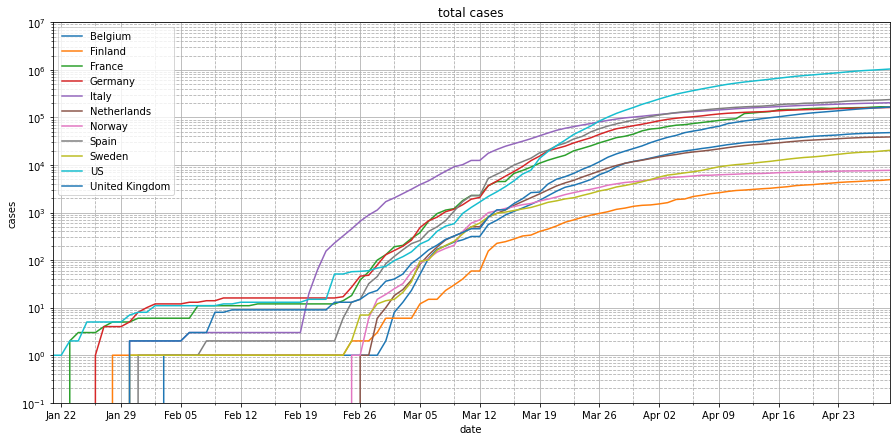

In [12]:
ax = plot_by_country(data, 'cases', 'total cases', logy=True)

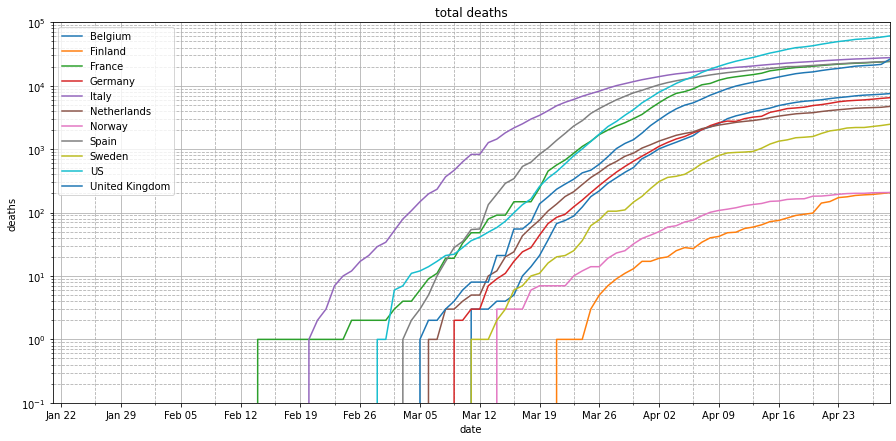

In [13]:
plot_by_country(data, 'deaths', 'total deaths', logy=True)

# Trigger date is when 100 cases are declared

In this section, for each country, day 0 is the day they had 100 cases.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

Keep in mind that some countries do more systematic checks (even of apparently healthy people) while others only check patients arriving at hospital with serious condition.

In [14]:
threshold = 1000
case_trigger = get_start_date(data, 'cases', threshold=threshold)
display(case_trigger)

country
Belgium          2020-03-16
Finland          2020-03-27
France           2020-03-08
Germany          2020-03-08
Italy            2020-02-29
Netherlands      2020-03-15
Norway           2020-03-14
Spain            2020-03-09
Sweden           2020-03-15
US               2020-03-11
United Kingdom   2020-03-14
Name: cases_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

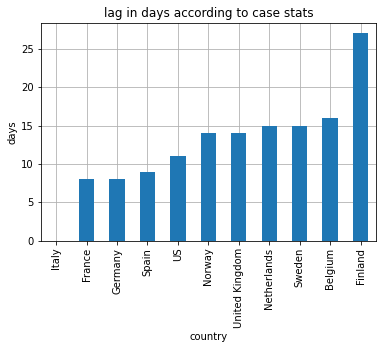

In [15]:
case_lags = case_trigger.apply(lambda x: x - case_trigger.min())
ax = case_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to case stats')
ax.set(ylabel='days')
plt.show()

In [16]:
case_offset_data = filter_by_trigger_date(data, 'cases', threshold=threshold)
case_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,1058,5
1 days,Belgium,1243,10
2 days,Belgium,1486,14
3 days,Belgium,1795,21
4 days,Belgium,2257,37
...,...,...,...
42 days,United Kingdom,148377,20319
43 days,United Kingdom,152840,20732
44 days,United Kingdom,157149,21092


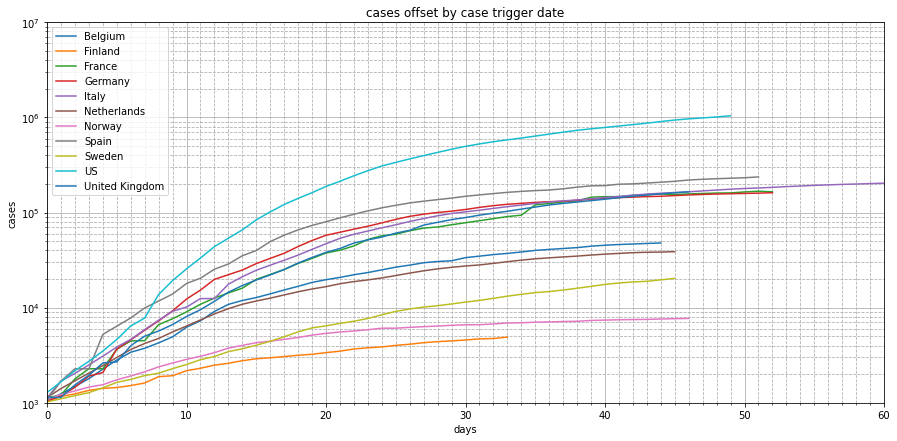

In [17]:
ax = plot_by_country(case_offset_data, 'cases', title='cases offset by case trigger date', logy=True)

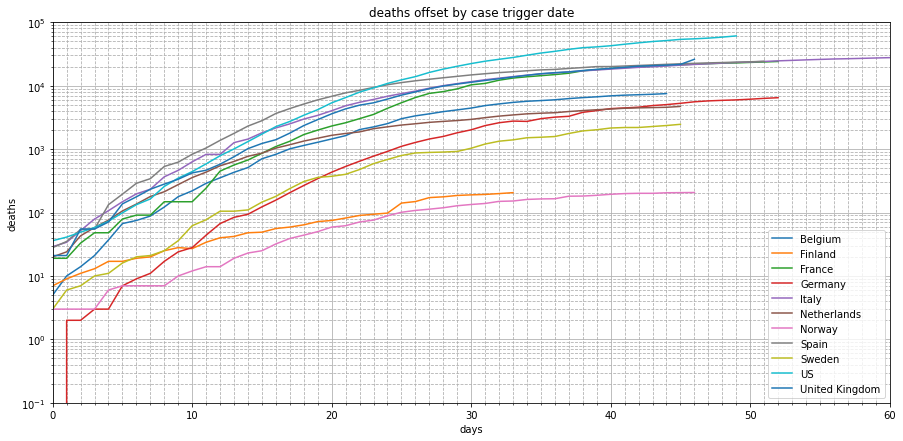

In [18]:
plot_by_country(case_offset_data, 'deaths', title='deaths offset by case trigger date', logy=True)

# Trigger date is when 20 deaths are declared
In this section, for each country, day 0 is the day they had 20 deaths.

Offsetting by this date, I plot the evolution of `cases` and `deaths`.

The reason I am looking at offsetting by death trigger date, is that the way different countries identify and count deaths is very similar, while for counting cases, some countries do systematic checks (leading to a low apparent mortality) and others check only serious cases ending in hospital (leading to a high apparent mortality)

In [19]:
threshold = 50
death_trigger = get_start_date(data, 'deaths', threshold=threshold)
display(death_trigger)

country
Belgium          2020-03-21
Finland          2020-04-12
France           2020-03-13
Germany          2020-03-20
Italy            2020-03-02
Netherlands      2020-03-18
Norway           2020-04-02
Spain            2020-03-11
Sweden           2020-03-25
US               2020-03-14
United Kingdom   2020-03-16
Name: deaths_trigger_date, dtype: datetime64[ns]

### Below is the offset for death trigger date compared to Italy (reference date)

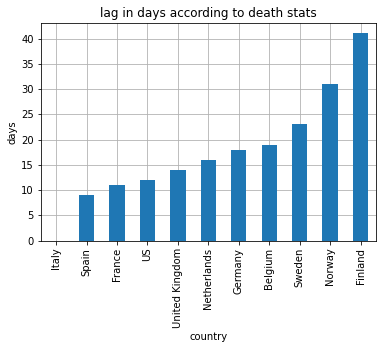

In [20]:
death_lags = death_trigger.apply(lambda x: x - death_trigger.min())
ax = death_lags.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [21]:
death_offset_data = filter_by_trigger_date(data, 'deaths', threshold=threshold)
death_offset_data

,country,cases,deaths
date,,,
0 days,Belgium,2815,67
1 days,Belgium,3401,75
2 days,Belgium,3743,88
3 days,Belgium,4269,122
4 days,Belgium,4937,178
...,...,...,...
40 days,United Kingdom,148377,20319
41 days,United Kingdom,152840,20732
42 days,United Kingdom,157149,21092


### lags between countries

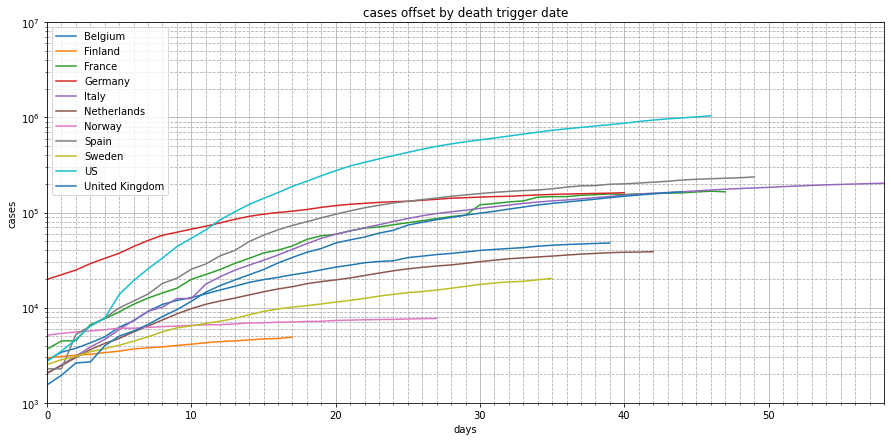

In [22]:
plot_by_country(death_offset_data, 'cases', title='cases offset by death trigger date', logy=True)

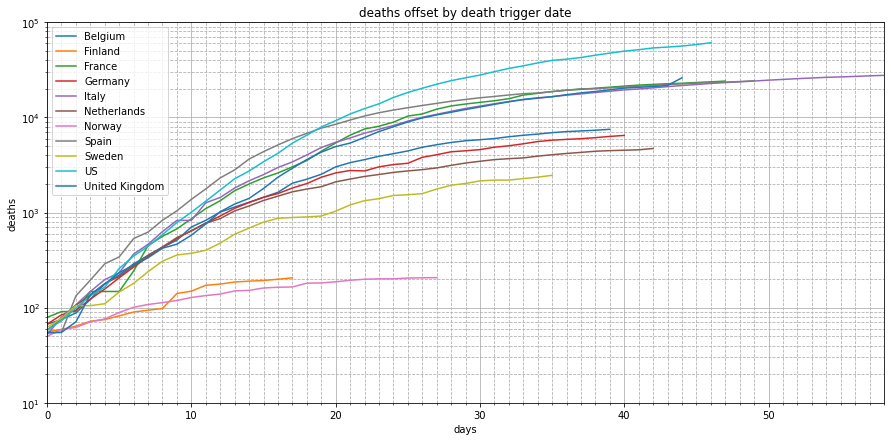

In [23]:
plot_by_country(death_offset_data, 'deaths', title='deaths offset by death trigger date', logy=True)

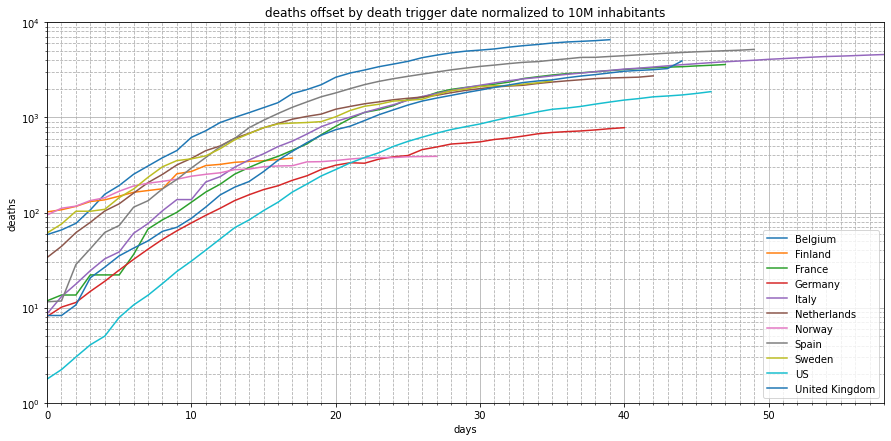

In [24]:
plot_by_country_normalize(death_offset_data, 'deaths', title='deaths offset by death trigger date normalized to 10M inhabitants', logy=True)

# Same as before but data is normalized to a population of 10M

In [25]:
normalized_data = normalize_to_population(data)

country
Belgium          2020-03-21
Finland          2020-04-05
France           2020-03-20
Germany          2020-03-28
Italy            2020-03-08
Netherlands      2020-03-20
Norway           2020-03-30
Spain            2020-03-15
Sweden           2020-03-25
US               2020-03-26
United Kingdom   2020-03-23
Name: deaths_trigger_date, dtype: datetime64[ns]

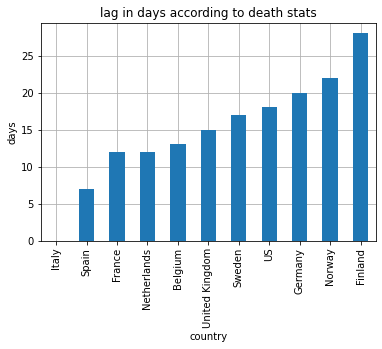

In [26]:
threshold = 50
death_trigger_norm = get_start_date(normalized_data, 'deaths', threshold=threshold)
display(death_trigger_norm)

death_lags_norm = death_trigger_norm.apply(lambda x: x - death_trigger_norm.min())
ax = death_lags_norm.sort_values().astype('timedelta64[D]').rename('days').plot(kind='bar', grid=True, zorder=2, title='lag in days according to death stats')
ax.set(ylabel='days')
plt.show()

In [27]:
death_offset_data_norm = filter_by_trigger_date(normalized_data, 'deaths', threshold=threshold)
death_offset_data_norm

,country,cases,deaths
date,,,
0 days,Belgium,2462.115779,58.600979
1 days,Belgium,2974.655689,65.598111
2 days,Belgium,3273.783076,76.968451
3 days,Belgium,3733.844497,106.706261
4 days,Belgium,4318.105009,155.686184
...,...,...,...
33 days,United Kingdom,22325.644297,3057.311891
34 days,United Kingdom,22997.172570,3119.454212
35 days,United Kingdom,23645.529129,3173.621852


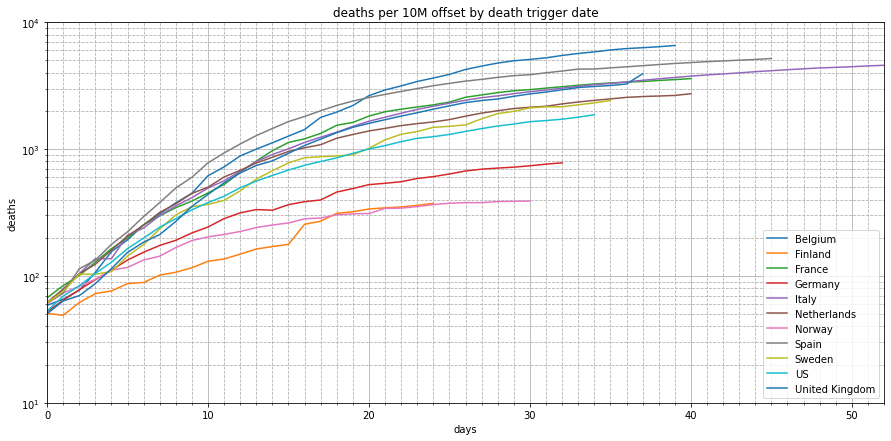

In [28]:
plot_by_country(death_offset_data_norm, 'deaths', title='deaths per 10M offset by death trigger date', logy=True)